![Задача №2](2.png)

In [3]:
# Данные
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

Y = list(map(float, "13.17, 11.78, 11.70, 12.54, 11.59, 11.21, 9.57, 9.07, 10.10, 10.60, 9.22, 7.91, 17.17, 14.74, 16.37, 15.34, 16.72, 16.53, 11.08, 12.01, 12.62, 11.07, 11.36, 11.78, 14.85, 14.60, 15.40, 13.23, 15.32, 13.23, 21.08, 20.70, 23.04, 21.22, 23.35, 22.51, 20.08, 18.89, 21.47, 19.55, 20.88, 20.01, 17.06, 18.76, 18.05, 17.83, 17.33, 18.30".split(", ")))
A = [1]*24 + [2]*24
B = [1]*6 + [2]*6 + [3]*6 + [4]*6 + [1]*6 + [2]*6 + [3]*6 + [4]*6

df = pd.DataFrame({"Y": Y, "A": A, "B": B})

Y = df["Y"]
A = df["A"]
B = df["B"]
alpha = 0.02
h = 0.82

df.head()


Y  A  B
0  13.17  1  1
1  11.78  1  1
2  11.70  1  1
3  12.54  1  1
4  11.59  1  1

## Пункт а)
### 1. Формулировка модели двухфакторного дисперсионного анализа
Модель с взаимодействием факторов:
$$
Y_{ijk} = \mu + \alpha_i + \beta_j + (\alpha \beta)_{ij} + \epsilon_{ijk},
$$
где:
- $Y_{ijk}$ — наблюдаемое значение переменной $Y$ для $i$-го уровня фактора $A$, $j$-го уровня фактора $B$, $k$-го повторения,
- $\mu$ — общее среднее,
- $\alpha_i$ — эффект $i$-го уровня фактора $A$,
- $\beta_j$ — эффект $j$-го уровня фактора $B$,
- $(\alpha \beta)_{ij}$ — эффект взаимодействия факторов $A$ и $B$,
- $\epsilon_{ijk} \sim N(0, \sigma^2)$ — случайная ошибка.

### 2. Построение МНК-оценок параметров

In [4]:
from statsmodels.formula.api import ols

# Формируем модель с взаимодействием
model_full = ols('Y ~ C(A) + C(B) + C(A):C(B)', data=df).fit()

# МНК-оценки параметров
params = model_full.params
print("Оценки параметров полной модели:")
print(params)

Оценки параметров полной модели:
Intercept              11.998333
C(A)[T.2]               2.440000
C(B)[T.2]              -2.586667
C(B)[T.3]               4.146667
C(B)[T.4]              -0.345000
C(A)[T.2]:C(B)[T.2]    10.131667
C(A)[T.2]:C(B)[T.3]     1.561667
C(A)[T.2]:C(B)[T.4]     3.795000
dtype: float64


### 3. Несмещенная оценка дисперсии
Несмещенная оценка дисперсии ошибок:
$$
\hat{\sigma}^2 = \frac{SS_{\text{res}}}{df_{\text{res}}},
$$
где:
- $SS_{\text{res}}$ — сумма квадратов остатков,
- $df_{\text{res}} = n - p$ — степени свободы ($n$ — число наблюдений, $p$ — число параметров).

In [5]:
# Несмещенная оценка дисперсии
sigma2 = model_full.mse_resid
print(f"Несмещенная оценка дисперсии: {sigma2:.3f}")

Несмещенная оценка дисперсии: 0.757


## Пункт b)

In [6]:
# Группируем данные по комбинациям A и B, вычисляем средние Y
grouped = df.groupby(['A', 'B'])['Y'].mean().reset_index()

# Создаём сводную таблицу для визуализации
pivot_table = grouped.pivot(index='A', columns='B', values='Y')
print("Сводная таблица средних значений Y:")
print(pivot_table)

Сводная таблица средних значений Y:
B          1          2          3          4
A                                            
1  11.998333   9.411667  16.145000  11.653333
2  14.438333  21.983333  20.146667  17.888333


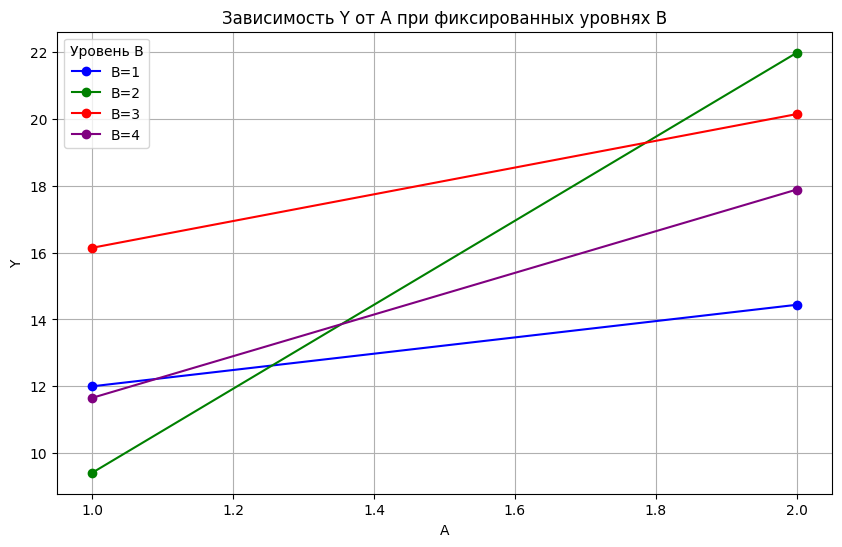

In [7]:
plt.figure(figsize=(10, 6))

# Уровни фактора B
B_levels = df['B'].unique()

# Цвета для каждого уровня B
colors = ['blue', 'green', 'red', 'purple']

for b, color in zip(B_levels, colors):
    # Фильтруем данные для текущего уровня B
    subset = grouped[grouped['B'] == b]
    plt.plot(subset['A'], subset['Y'], 
             marker='o', 
             linestyle='-', 
             color=color, 
             label=f'B={b}')

plt.xlabel('A')
plt.ylabel('Y')
plt.title('Зависимость Y от A при фиксированных уровнях B')
plt.legend(title='Уровень B')
plt.grid(True)
plt.show()

### Визуальная проверка аддитивности:

- **Пересечение линий:** График зависимости $Y$ от $A$ при фиксированных $B$ показывает, что линии для разных уровней $B$ пересекаются, особенно при $B=4$. Это указывает на **наличие взаимодействия** между факторами.
- **Следствия:** Взаимодействие факторов может означать, что влияние одного фактора на зависимую переменную $Y$ зависит от другого фактора.


## Пункт c)

In [8]:
from statsmodels.formula.api import ols

# Аддитивная модель
model_additive = ols('Y ~ C(A) + C(B)', data=df).fit()

# Остатки модели
residuals = model_additive.resid

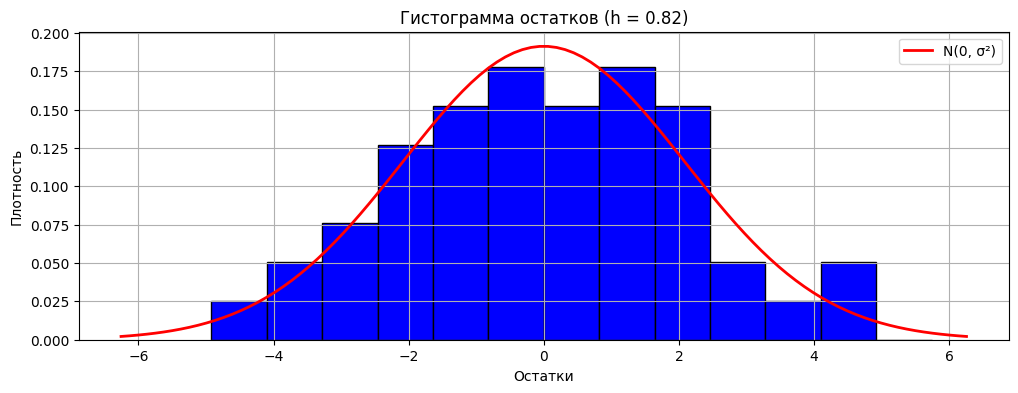

In [9]:
# Определение границ бинов
min_res = np.floor(residuals.min() / h) * h
max_res = np.ceil(residuals.max() / h) * h
bin_edges = np.arange(min_res, max_res + h, h)

# Гистограмма
plt.figure(figsize=(12, 4))
plt.hist(residuals, bins=bin_edges, density=True, color='blue', edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Плотность')
plt.title('Гистограмма остатков (h = 0.82)')
plt.grid(True)

# Наложение нормального распределения
mu = 0  # Остатки центрированы вокруг 0
sigma = np.std(residuals)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2)), 
         color='red', linewidth=2, label='N(0, σ²)')
plt.legend()
plt.show()

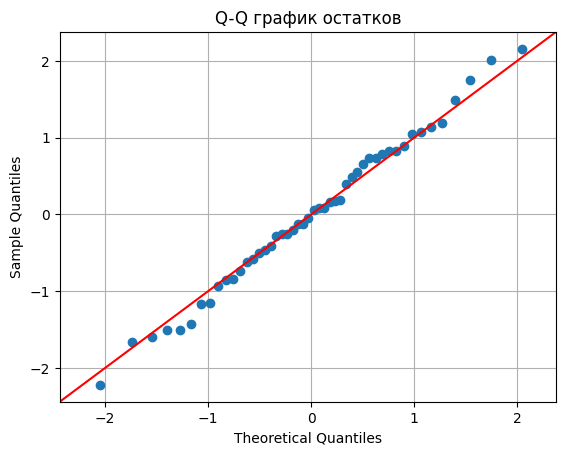

In [18]:
import statsmodels.api as sm

sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q график остатков')
plt.grid(True)
plt.show()

In [11]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Тест Шапиро-Уилка: p-value = {p_value:.3f}")
if p_value < 0.02:
    print("Отвергаем H₀: остатки не нормальны.")
else:
    print("Не отвергаем H₀: остатки нормальны.")

Тест Шапиро-Уилка: p-value = 0.949
Не отвергаем H₀: остатки нормальны.


### Результаты
- **Гистограмма:** Распределение остатков близко к нормальному, совпадает с наложенной кривой $N(0, \sigma^2)$.
- **Q-Q график:** Точки лежат вдоль линии $y=x$, что подтверждает нормальность.
- **Тест Шапиро-Уилка:** гипотеза о нормальности не отвергается.

## Пункт d)

In [20]:
from statsmodels.stats.anova import anova_lm

# ANOVA с взаимодействием
anova_table = anova_lm(model_full)
print("Таблица ANOVA:")
print(anova_table)

Таблица ANOVA:
             df      sum_sq     mean_sq           F        PR(>F)
C(A)        1.0  478.108752  478.108752  631.694471  4.061068e-26
C(B)        3.0  153.241356   51.080452   67.489330  1.051893e-15
C(A):C(B)   3.0  178.558140   59.519380   78.639144  8.022881e-17
Residual   40.0   30.274683    0.756867         NaN           NaN


### Результаты ANOVA
Из таблицы ANOVA:
- **Фактор A:**
  $$
  F = 631.69,\ p\text{-value} < 0.001 \ \rightarrow \ \text{значимо влияет на } Y.
  $$
  
- **Фактор B:**
  $$
  F = 67.49,\ p\text{-value} < 0.001 \ \rightarrow \ \text{значимо влияет на } Y.
  $$
  
- **Взаимодействие $A \times B$:**
  $$
  F = 78.64,\ p\text{-value} < 0.001 \ \rightarrow \ \text{значимо влияет на } Y.
  $$

- **Вывод:**
  На уровне значимости $\alpha=0.02$ все факторы (A, B) и их взаимодействие **значимо** ($p < 0.02$). Это означает, что влияние фактора A на Y зависит от уровня фактора B, и наоборот.

## Пункт e)
Для выбора оптимальной модели используются критерии:
- AIC оценивает баланс между качеством подгонки модели и её сложностью, накладывая штраф за избыточное количество параметров.
- BIC работает аналогично AIC, но применяет более строгий штраф за сложность, особенно при больших объемах данных.

Сравниваем две модели:
1. **Полная модель** (с взаимодействием): 
   $$
   Y \sim A + b + A : B.
   $$
2. **Аддитивная модель** (без взаимодействия):
   $$
   Y \sim A + B.
   $$

In [21]:
# Список моделей
models = {
    "Полная": model_full,
    "Аддитивная": model_additive
}

# Вывод AIC и BIC
print("Модель\t\tAIC\tBIC")
for name, model in models.items():
  print(f"{name}  \t{model.aic:.2f}\t{model.bic:.2f}")

Модель		AIC	BIC
Полная  	130.10	145.07
Аддитивная  	216.79	226.15


### Вывод о сравнении моделей

- **Результаты AIC и BIC:**
  - **AIC:** Полная модель имеет AIC = 130.10, в то время как аддитивная модель имеет AIC = 216.79. Это указывает на значительное преимущество полной модели.
  - **BIC:** Полная модель также имеет BIC = 145.07, а аддитивная модель — BIC = 226.15. Разница подтверждает выбор полной модели.

- **Заключение:**
  - Полная модель **предпочтительнее**, так как она лучше соответствует данным, что подтверждается меньшими значениями AIC и BIC.
  - Аддитивная модель не учитывает взаимодействие факторов.

## Пункт f)
### 1. Основные эффекты факторов A и B
- **Фактор A:**  
  Оказал **сильное статистически значимое влияние** на $Y$ ($F=631.69, p<0.001$).  


- **Фактор B:**  
  Также **значимо влияет** на $Y$ ($F=67.49, p<0.001$).  

### 2. Взаимодействие факторов $A \times B$
- **Статистическая значимость:**  
  Взаимодействие **значимо** ($F=78.64, p<0.001$).
  
- **Визуальное подтверждение:**  
  График зависимости $Y$ от $A$ при фиксированных $B$ показывает пересечение линий (особенно для $B=4$), что указывает на **неаддитивность эффектов**.


### 3. Выбор оптимальной модели
- **AIC/BIC:**  
  | Модель          | AIC    | BIC    |
  |-----------------|--------|--------|
  | Полная (с взаимодействием) | 130.10 | 145.07 |
  | Аддитивная      | 216.79 | 226.15 |

  - Разница $\Delta AIC = 86.69$ и $\Delta BIC = 81.08$ **явно указывает на преимущество полной модели**.  
  - Аддитивная модель не учитывает взаимодействие, что приводит к потере информации.


### 4. Нормальность остатков
- **Тест Шапиро-Уилка:**  
  $$p\text{-value} = 0.949 \implies \text{гипотеза о нормальности остатков не отвергается}.$$
- **Графическая проверка:**  
  - Гистограмма остатков близка к нормальной форме.  
  - Q-Q график показывает совпадение точек с линией $y = x$.


- **Рекомендации:**  
  Для прогнозирования $Y$ **необходимо учитывать взаимодействие** $A \times B$, так как его игнорирование приведет к систематической ошибке.


## Итоговый вывод
1. **Полная модель с взаимодействием** предпочтительна по критериям AIC/BIC и объясняет данные лучше аддитивной.  
2. **Нормальность остатков** подтверждена тестами и графиками.

**Рекомендации:**  
- Проверить данные на наличие выбросов для уровня $B=4$.  
- Использовать полную модель для прогнозирования и анализа эффектов.